In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
"""
membuat filepath(alamat direktori) dari setiap file
serta membuat labels(black/tricolor).
lalu di gabung menjadi dataframe.
"""
sdir=r'C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset\...  black
1  C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset\...  black
2  C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset\...  black
3  C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset\...  black
4  C:\Users\HpEducPro\Skripsi\PercobaanB\Dataset\...  black
labels
black        600
tri_color    600
Name: count, dtype: int64


In [12]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  960   test_df length:  120   valid_df length:  120


In [13]:
"""
image data processing
merubah bentuk image menjadi angka
"""
height=512
width=512
channels=3
batch_size=24

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        fill_mode='nearest'
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        fill_mode='nearest'
)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        fill_mode='nearest'
)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  60   test steps:  2
Found 960 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
['black', 'tri_color']


In [14]:
"""
function yang berfungsi untuk menampilkan
sample image yang di generator
"""
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

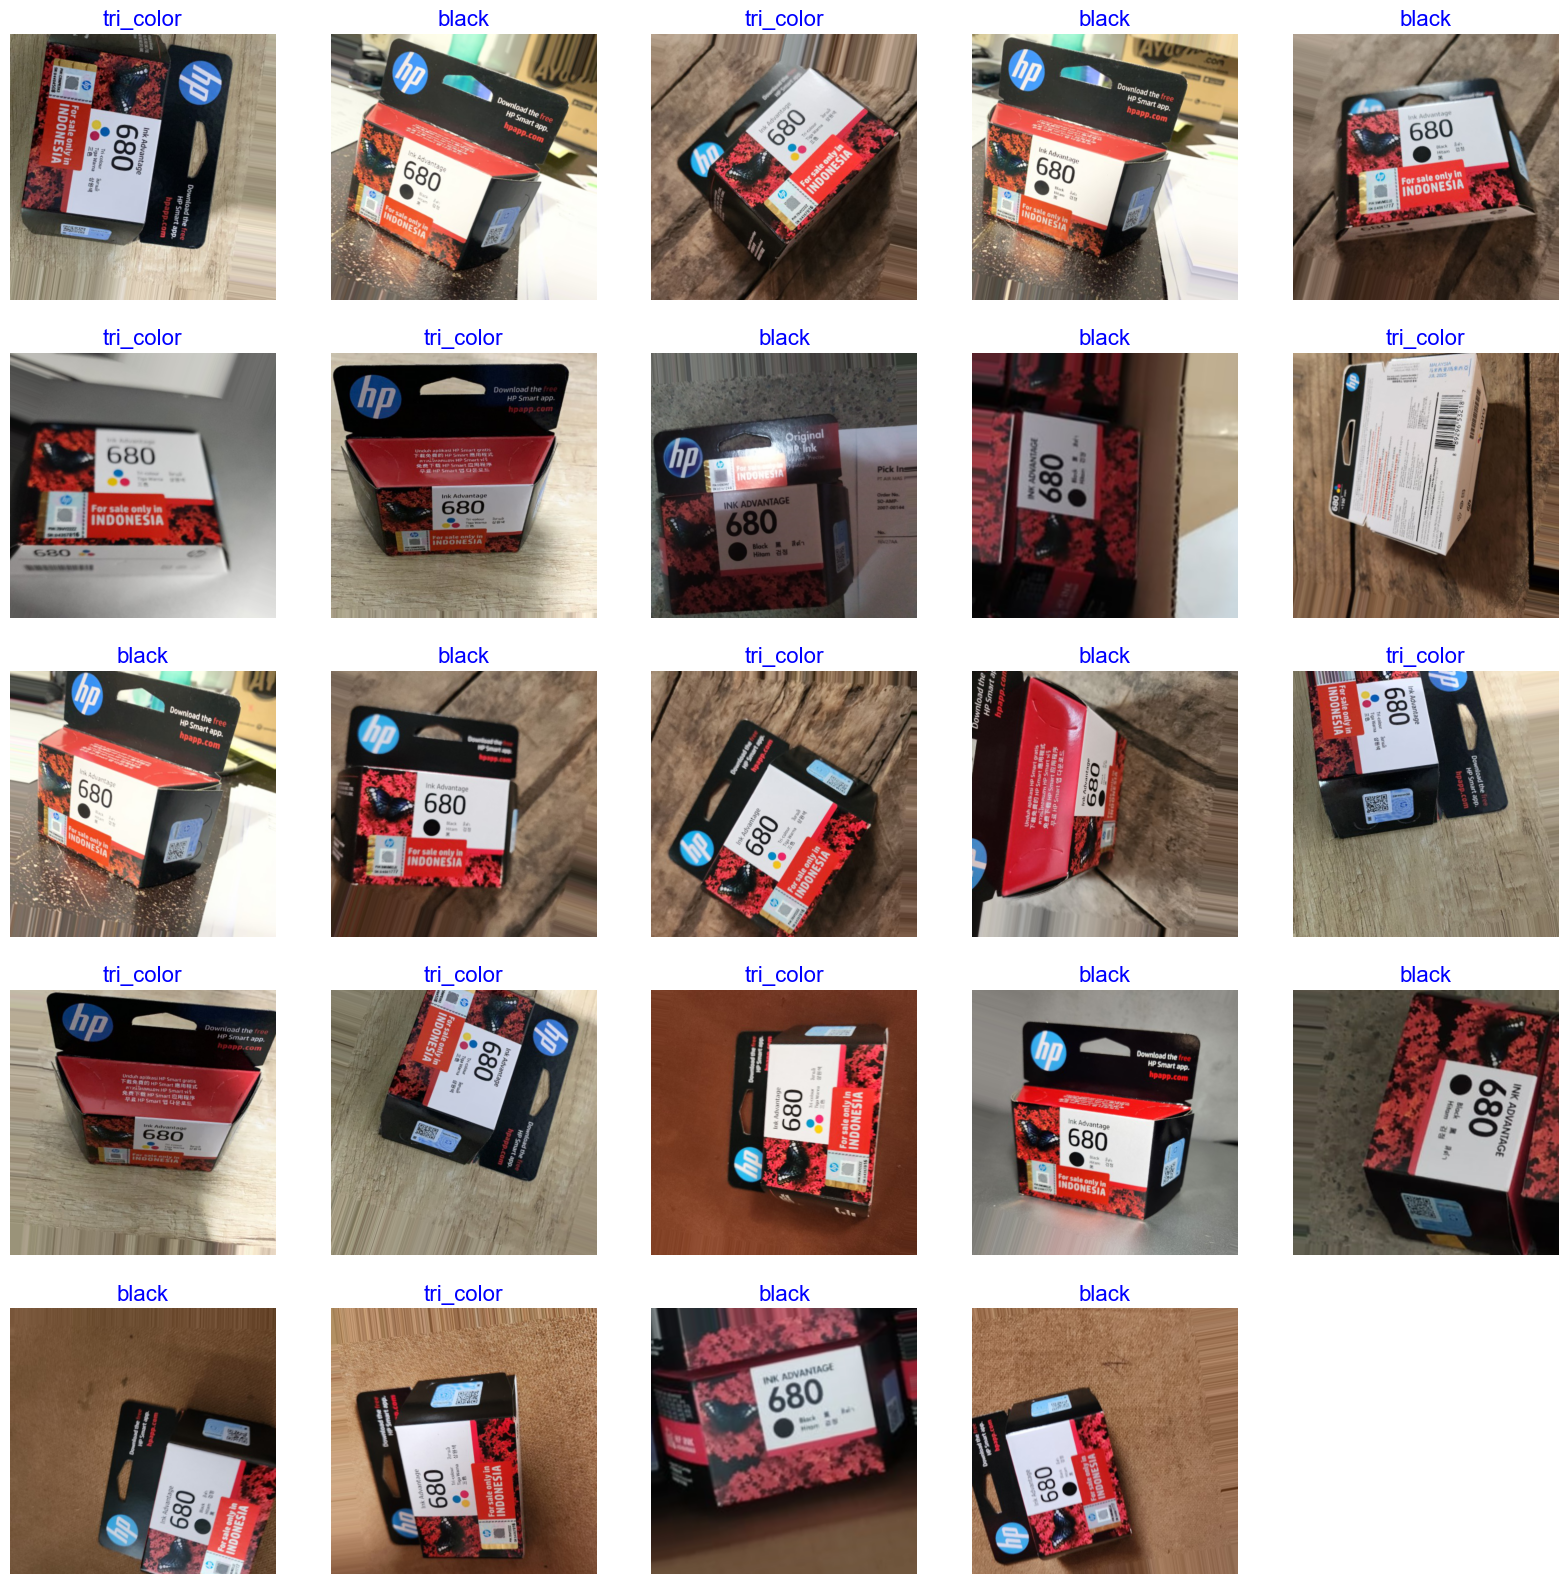

In [15]:
show_image_samples(train_gen)

In [16]:
"""
membuat model klasifikasi tinta dengan cnn
"""

model_name='Fajri'

model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=img_shape),
            tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            
            
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

            tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3),activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Dropout(0.5),
                                        
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(class_count, activation='sigmoid')
])
                                        
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 510, 510, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 255, 255, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 253, 253, 32)        │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 124, 124, 8)         │           2,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │          61,506 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,298 (407.41 KB)

 Trainable params: 104,298 (407.41 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
"""
proses pelatihan pada model
menggunakan model yang sudah di buat dan data training
"""
epochs=50

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)    

Epoch 1/50


C:\Users\HpEducPro\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 338s 7s/step - accuracy: 0.5319 - loss: 0.6915 - val_accuracy: 0.7750 - val_loss: 0.5103
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 298s 7s/step - accuracy: 0.6514 - loss: 0.6353 - val_accuracy: 0.7250 - val_loss: 0.5606
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 298s 7s/step - accuracy: 0.7166 - loss: 0.5460 - val_accuracy: 0.7833 - val_loss: 0.5073
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 292s 7s/step - accuracy: 0.7351 - loss: 0.5367 - val_accuracy: 0.7333 - val_loss: 0.4671
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 315s 7s/step - accuracy: 0.7427 - loss: 0.4900 - val_accuracy: 0.7917 - val_loss: 0.4561
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 289s 7s/step - accuracy: 0.7970 - loss: 0.4481 - val_accuracy: 0.8083 - val_loss: 0.4109
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 289s 7s/step - accuracy: 0.8110 - loss: 0.4411 - val_accuracy: 0.8667 - val_loss: 0.3381
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 302s 7s/step - accuracy: 0.8098 - loss: 0.4187 - val_accuracy: 0.8167 - val_loss: 0.

In [19]:
"""
function yang berfungsi untuk coloring text dan background textnya
"""

def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True)
    return

In [20]:
"""
function yang berfungsi untuk menampilkan loss dan akurasi
dari data pelatihan dan validasi setelah pelatihan
"""

def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [21]:
"""
function yang berfungsi untuk report hasil akhir
seperti jumlah error dan actual dari test dengan confusion matrix
dalam bentuk visual data.
klasifikasi report.
"""

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key

    classes=list(new_dict.values())
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
            
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        # sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       

                # Menampilkan array sebagai tabel
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        
        # Menambahkan teks di dalam setiap sel
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
        
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

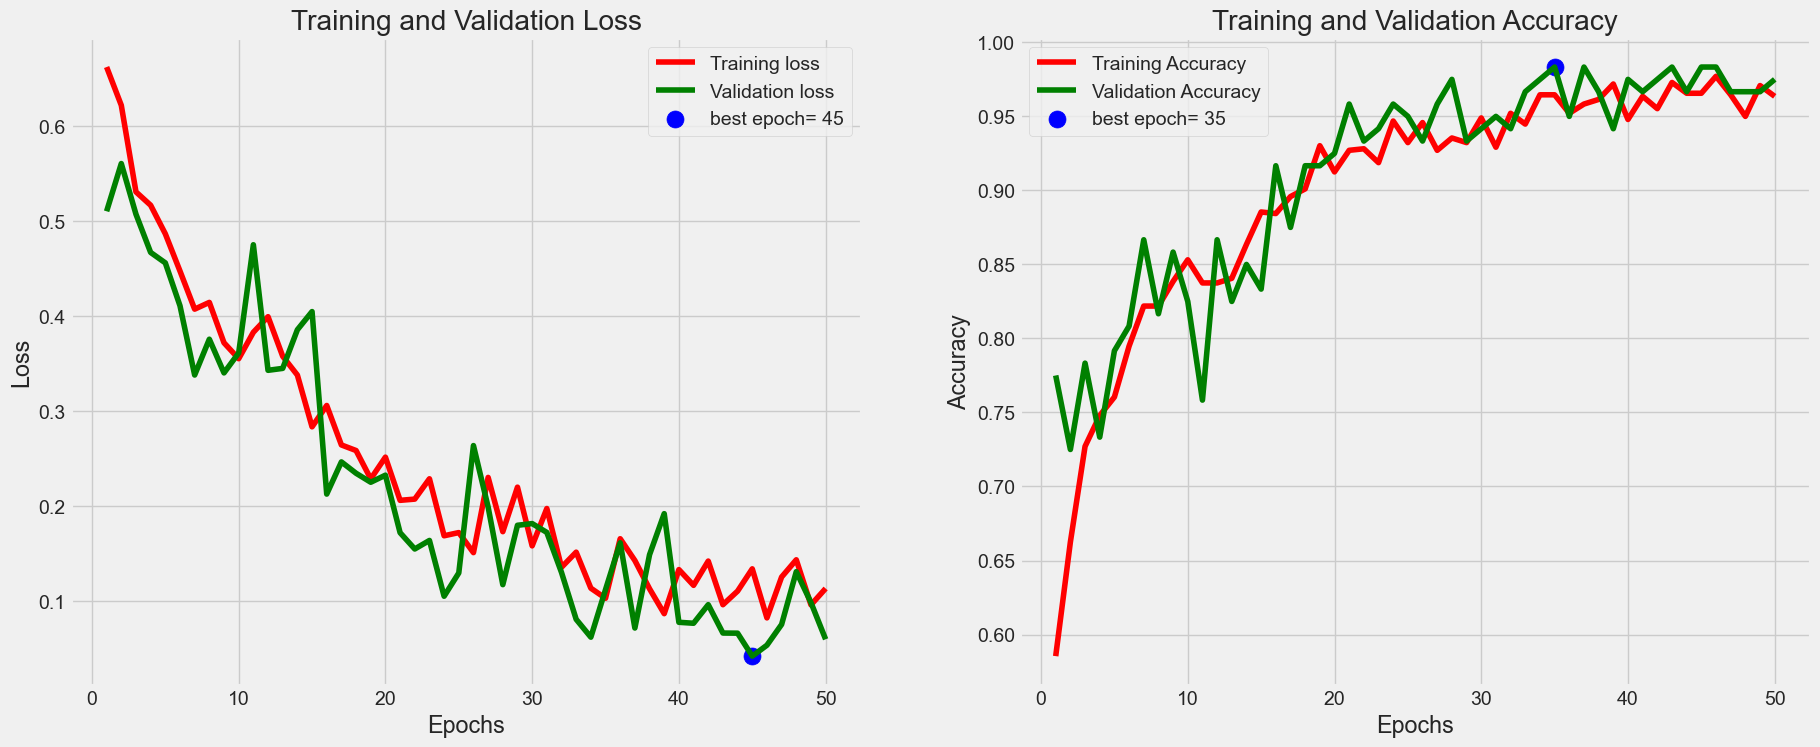

C:\Users\HpEducPro\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 143s 44s/step - accuracy: 0.9722 - loss: 0.1861
accuracy on the test set is 96.67 %



In [22]:
tr_plot(history,0)
save_dir=r'./'
subject='tinta'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
# model.save(save_loc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 34s/step


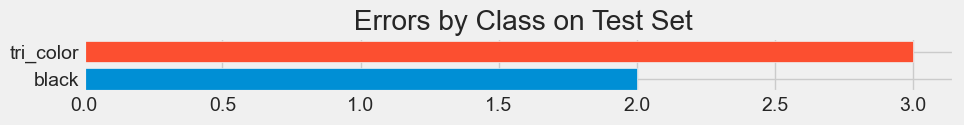

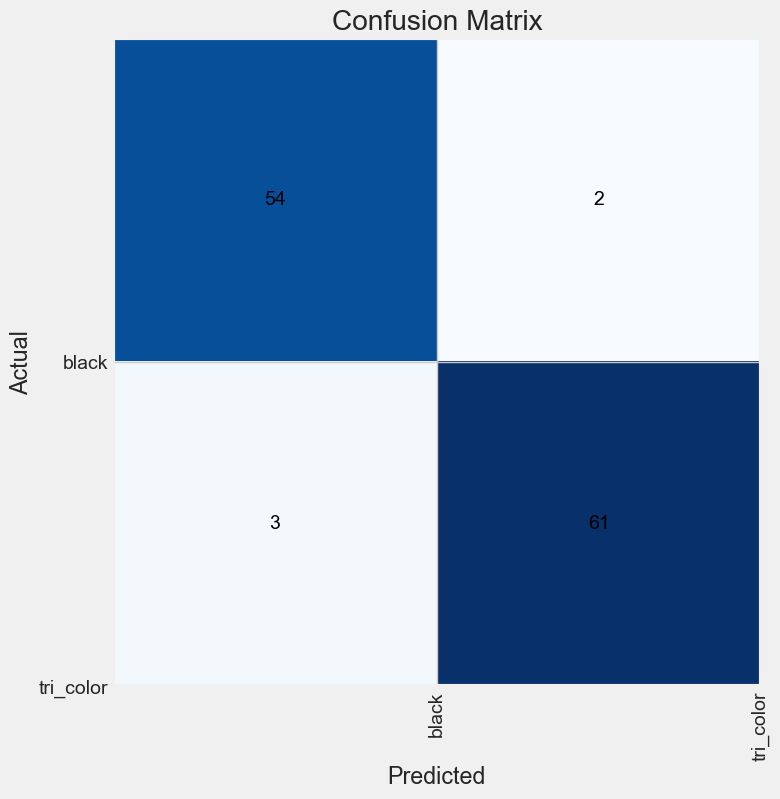

Classification Report:
----------------------
               precision    recall  f1-score   support

       black       0.95      0.96      0.96        56
   tri_color       0.97      0.95      0.96        64

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



In [23]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  

In [24]:
subject='PercobaanB'
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)